## how many new lncRNAs have a qtl?

In [17]:
import pandas as pd
import seaborn as sns
import pyranges as pr
import numpy as np
import matplotlib.pyplot as plt
import upsetplot as up
from matplotlib.colors import hex2color
from scipy.stats.kde import gaussian_kde
from matplotlib.colors import LogNorm
from scipy import stats
import os
from scipy.stats import sem


from tqdm.notebook import tqdm

tqdm.pandas()

/local/scratch/klawren/slrmtmp.47796407/ipykernel_30391/1650888010.py:8: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


In [20]:
# pull in the gene ids
gencode_ids = pd.read_csv('/home/klawren/oak/gtex/data/other_references/gencode_id_matching.txt', sep='\t')

/local/scratch/klawren/slrmtmp.47796407/ipykernel_30391/296535853.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gencode_ids = pd.read_csv('/home/klawren/oak/gtex/data/other_references/gencode_id_matching.txt', sep='\t')


In [22]:
# load in the v11 qtls
v11_eqtl = pd.read_csv('/home/klawren/oak/gtex/output/caudate_analysis/eqtls/Brain_Caudate_basal_ganglia.v11.eGenes.txt.gz', sep='\t')
v11_sqtl= pd.read_csv('/home/klawren/oak/gtex/output/caudate_analysis/sqtls/Brain_Caudate_basal_ganglia.v11.sGenes.txt.gz', sep='\t')

# are they signifignat?
v11_eqtl['signifigant'] = v11_eqtl['qval'] < 0.05
v11_sqtl['signifigant']  = v11_sqtl['qval'] < 0.05

In [23]:
v10_eqtl = pd.read_csv('/home/klawren/oak/gtex/data/other_references/v10/qtls/GTEx_Analysis_v10_eQTL_updated/Brain_Caudate_basal_ganglia.v10.eGenes.txt.gz', sep='\t')
v10_sqtl = pd.read_csv('/home/klawren/oak/gtex/data/other_references/v10/qtls/GTEx_Analysis_v10_sQTL_updated/Brain_Caudate_basal_ganglia.v10.sGenes.txt.gz', sep='\t')

# are they signifignat?
v10_eqtl['signifigant'] = v10_eqtl['qval'] < 0.05
v10_sqtl['signifigant']  = v10_sqtl['qval'] < 0.05


In [24]:
# combine into one df
def comine_qtls(gencode_ids, eqtls, sqtls):
    qtls = pd.merge(eqtls[['signifigant', 'gene_id', 'variant_id']], gencode_ids, left_on='gene_id', right_on='gene_id_v47', how='outer')
    qtls = pd.merge(sqtls[['signifigant', 'gene_id', 'variant_id']], qtls, left_on='gene_id', right_on='gene_id_v47', suffixes=['_s', '_e'],  how='outer').drop(columns=['gene_id_s', 'gene_id_e'])
    qtls[['signifigant_s', 'signifigant_e']] = qtls[['signifigant_s', 'signifigant_e']].fillna(False)
    return qtls

v11_qtls = comine_qtls(gencode_ids, v11_eqtl, v11_sqtl)
v10_qtls = comine_qtls(gencode_ids, v10_eqtl, v10_sqtl)

# combine the v10 and v11
qtls = pd.merge(v11_qtls, v10_qtls[['signifigant_s', 'signifigant_e', 'gene_id_stable', 'variant_id_e', 'variant_id_s']], on='gene_id_stable', suffixes=['_v11', '_v10'])
qtls['is_hit'] = qtls['signifigant_s_v10'] + qtls['signifigant_e_v10'] +qtls['signifigant_s_v11'] + qtls['signifigant_e_v11']
gene_type_order = ['lncRNA', 'protien_coding', 'pseudogene', 'noncoding_RNA', 'artifact']
qtls['gene_type_grouped'] = pd.Categorical(qtls['gene_type_grouped'], categories=gene_type_order, ordered=True)

In [30]:
# calculate pi1
print('eQTLs pi1:')
print(qtls[qtls['signifigant_e_v10']].groupby('gene_type_grouped')['signifigant_e_v11'].mean())
print('overall: {}'.format(qtls[qtls['signifigant_e_v10']]['signifigant_e_v11'].mean()))
print('\n \nsQTLs pi1:')
print(qtls[qtls['signifigant_s_v10']].groupby('gene_type_grouped')['signifigant_s_v11'].mean())
print('overall: {}'.format(qtls[qtls['signifigant_s_v10']]['signifigant_s_v11'].mean()))

eQTLs pi1:
gene_type_grouped
lncRNA            0.941784
protien_coding    0.924123
pseudogene        0.628272
noncoding_RNA          NaN
artifact               NaN
Name: signifigant_e_v11, dtype: float64
overall: 0.9072553805191924

 
sQTLs pi1:
gene_type_grouped
lncRNA            1.000000
protien_coding    0.983673
pseudogene        0.285714
noncoding_RNA          NaN
artifact               NaN
Name: signifigant_s_v11, dtype: float64
overall: 0.9732338745063625


In [ ]:
# calculate pi1 for a subset
qtls_in_both = qtls[qtls['match_level'] == 'full_match']
print('eQTLs pi1:')
print(qtls_in_both[qtls_in_both['signifigant_e_v10']].groupby('gene_type_grouped')['signifigant_e_v11'].mean())
print('overall: {}'.format(qtls_in_both[qtls_in_both['signifigant_e_v10']]['signifigant_e_v11'].mean()))
print('\n \nsQTLs pi1:')
print(qtls_in_both[qtls_in_both['signifigant_s_v10']].groupby('gene_type_grouped')['signifigant_s_v11'].mean())
print('overall: {}'.format(qtls_in_both[qtls_in_both['signifigant_s_v10']]['signifigant_s_v11'].mean()))


eQTLs pi1:
gene_type_grouped
lncRNA            0.950049
protien_coding    0.926199
pseudogene        0.877660
noncoding_RNA          NaN
artifact               NaN
Name: signifigant_e_v11, dtype: float64
overall: 0.926984126984127

 
sQTLs pi1:
gene_type_grouped
lncRNA            1.000000
protien_coding    0.984608
pseudogene        0.857143
noncoding_RNA          NaN
artifact               NaN
Name: signifigant_s_v11, dtype: float64
overall: 0.9844509232264335


In [66]:
# which ones fail to replicate?
replication_failures = qtls_in_both[(qtls_in_both['signifigant_e_v10'] & ~(qtls_in_both['signifigant_e_v11']))]
print(len(replication_failures[~(replication_failures['gene_id_v47'].isin(v11_eqtl['gene_id']))]))
replication_failures['gene_type'].value_counts()

24


gene_type
protein_coding                        492
lncRNA                                 51
processed_pseudogene                   25
transcribed_unprocessed_pseudogene     16
TEC                                     8
unprocessed_pseudogene                  3
transcribed_processed_pseudogene        2
misc_RNA                                1
Name: count, dtype: int64

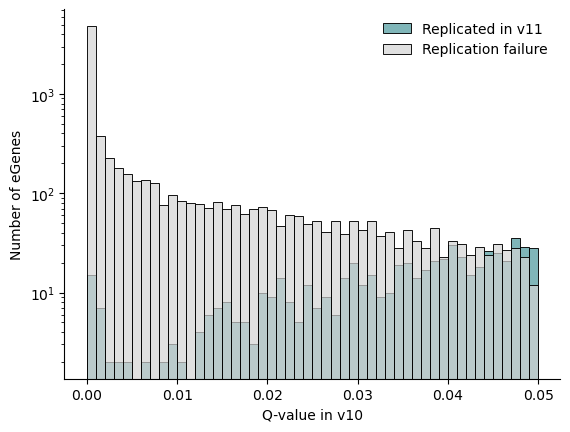

In [86]:
v10_eqtl['replicaiton_failure'] = v10_eqtl['gene_id'].isin(replication_failures['gene_id_v39'])
ax = sns.histplot(v10_eqtl[(v10_eqtl['signifigant']) & (v10_eqtl['gene_id'].isin(qtls_in_both['gene_id_v39']))], x='qval', bins=50, hue='replicaiton_failure', palette=['lightgrey', '#4a989c'], alpha=.7)
ax.set_xlabel('Q-value in v10')
ax.set_ylabel('Number of eGenes')
ax.set_yscale('log')


ax.legend(['Replicated in v11', 'Replication failure'])
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title('')
ax.spines[['top', 'right']].set_visible(False)


/local/scratch/klawren/slrmtmp.47796407/ipykernel_30391/591579959.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tissue_labels, fontsize=10)


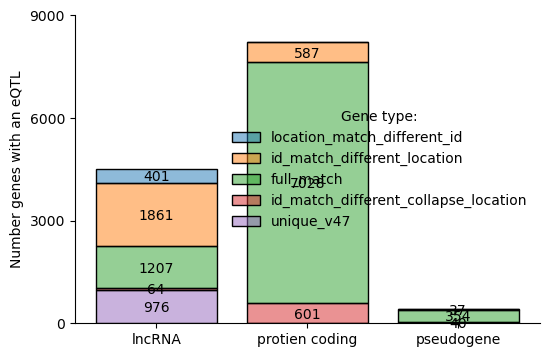

In [33]:
# how many new genes have a QTLs?

fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(qtls[qtls['signifigant_e_v11']& ~(qtls['gene_type_grouped'] == 'artifact')], x='gene_type_grouped', hue='match_level',
             multiple='stack', alpha=0.5, shrink=.8, ax=ax)
            # palette=[ '#b70657', '#fb7cb6', 'grey'])

# add numbers to plot
for container in ax.containers:
    labels = [f'{int(height)}' if height > 20  else '' for height in container.datavalues]
    ax.bar_label(container, labels=labels, padding=-1, fontsize=10, label_type='center')


# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_xticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_xticklabels(tissue_labels, fontsize=10)
ax.set_xlabel('')
ax.set_ylabel('Number genes with an eQTL')
ax.set_yticks([0, 3000, 6000, 9000])

# legend

#ax.legend(['Existing', 'Partial match to v47', 'New in v47'])
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title("Gene type:")

ax.spines[['top', 'right']].set_visible(False)
    

/local/scratch/klawren/slrmtmp.47796407/ipykernel_30391/2147781671.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tissue_labels, fontsize=10)


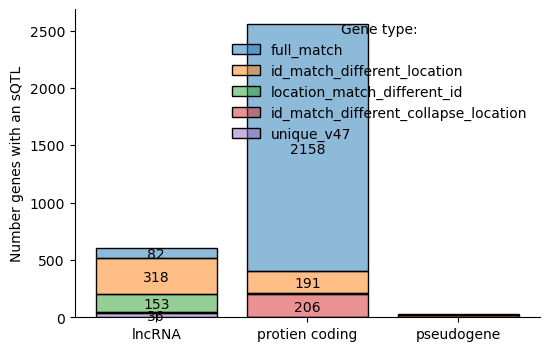

In [35]:
# how many new genes have a QTLs?
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(qtls[qtls['signifigant_s_v11']& ~(qtls['gene_type_grouped'] == 'artifact')], x='gene_type_grouped', hue='match_level',
             multiple='stack', alpha=0.5, shrink=.8, ax=ax)

# add numbers to plot
for container in ax.containers:
    labels = [f'{int(height)}' if height > 20  else '' for height in container.datavalues]
    ax.bar_label(container, labels=labels, padding=-1, fontsize=10, label_type='center')


# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_xticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_xticklabels(tissue_labels, fontsize=10)
ax.set_xlabel('')
ax.set_ylabel('Number genes with an sQTL')
#ax.set_yticks([0, 3000, 6000, 9000])

# legend

legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title("Gene type:")

ax.spines[['top', 'right']].set_visible(False)
    

### upset plot of how many genes have a signifignat hit

In [36]:
qtls['is_hit'] = qtls['signifigant_s_v10'] + qtls['signifigant_e_v10'] +qtls['signifigant_s_v11'] + qtls['signifigant_e_v11']

In [37]:
# rename for upset plot
upset_sig_bool = qtls[~(qtls['in_collapsed'] == 'neither') & (qtls['is_hit'])].set_index('signifigant_s_v10').set_index('signifigant_e_v10', append=True).set_index('signifigant_s_v11', append=True).set_index('signifigant_e_v11', append=True)
upset_sig_bool.index.set_names(['v10 sQTL', 'v10 eQTL', 'v11 sQTL', 'v11 eQTL'], inplace=True)

dict_keys(['matrix', 'shading', 'totals', 'extra0'])


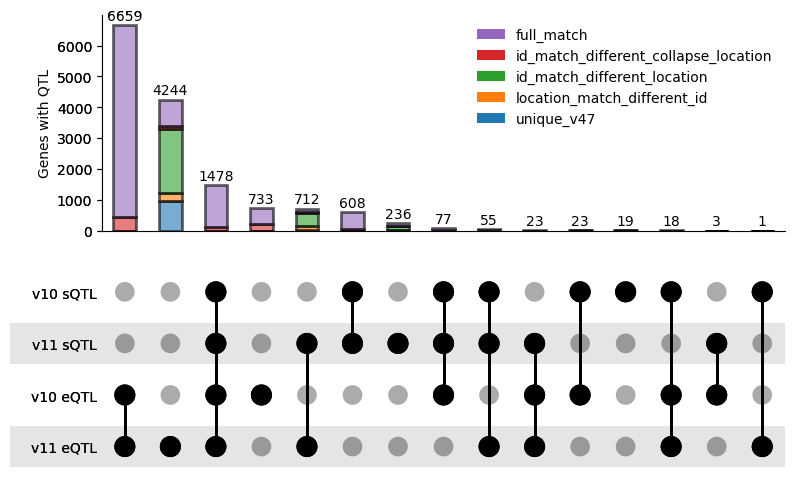

In [40]:
fig = plt.figure(figsize=(10, 6))

upset = up.UpSet(upset_sig_bool, intersection_plot_elements=0, totals_plot_elements=0, show_counts=True, 
                 element_size=None, sort_by='cardinality', min_subset_size=1)  # disable the default bar chart
upset.add_stacked_bars(by="match_level", title="", elements=4)
plot_result = upset.plot(fig=fig)


# style the instersection plot
plot_result = upset.plot(fig=fig)
print(plot_result.keys())

# style the stacked bar plot
stackedbar_plot = plot_result["extra0"]
stackedbar_plot.grid(False)
stackedbar_plot.set_ylabel('Genes with QTL')
stackedbar_plot.spines['bottom'].set_visible(True)

# Customize the bars to have an alpha transparency and black outlines
for bar in stackedbar_plot.patches:
    bar.set_edgecolor('black')  # Add black edge outline
    bar.set_linewidth(2)  # Set the width of the edge outline
    bar.set_alpha(0.6)  # Set transparency
    
# add a legend
#plt.legend(labels=['Location only in v47', 'Location only in v39', 'Location in both,\ndifferent ID', 'ID in both'], bbox_to_anchor=(1.05, 1), loc='upper left', title='ID match level')
leg = plt.gca().get_legend()
leg.set_frame_on(False)

plt.show()

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


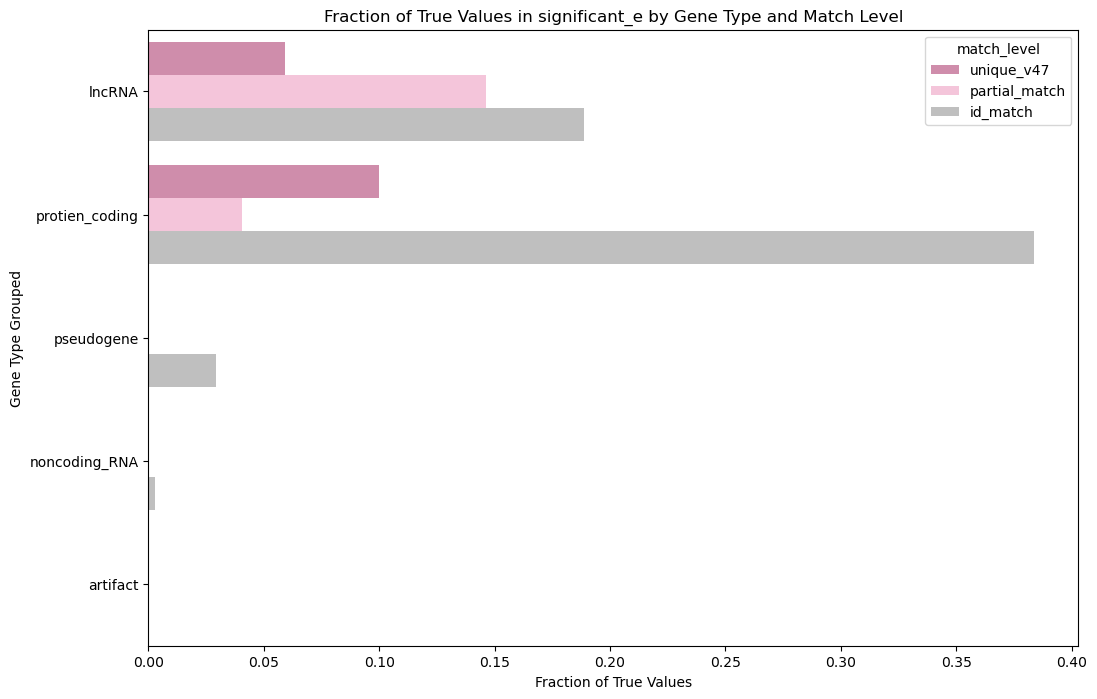

In [ ]:
# Calculate the fraction of true values in significant_e for each combination of gene_type_grouped and match_level
grouped = qtls[~(qtls['gene_type_grouped'] == 'artifact')].groupby(['gene_type_grouped', 'match_level'])['signifigant_e_v11']
fraction_true = grouped.mean().reset_index()
fraction_true.columns = ['gene_type_grouped', 'match_level', 'fraction_true']
fraction_true['sem'] = grouped.apply(sem).reset_index(drop=True)

# Create the plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=fraction_true, y='gene_type_grouped', x='fraction_true', hue='match_level', palette=[ '#b70657', '#fb7cb6', 'grey'], hue_order=['unique_v47', 'partial_match', 'id_match'], alpha=.5)


# Set the title and labels
ax.set_title('Fraction of True Values in significant_e by Gene Type and Match Level')
ax.set_xlabel('Fraction of True Values')
ax.set_ylabel('Gene Type Grouped')

# Show the plot
plt.show()

### are the eqtls for the new genes new eqtls?

In [ ]:
# p values for other v10 genes for the new gene qlts

new_eqtls = qtls[(qtls['signifigant_e_v11']) & (qtls['match_level'].isin(['unique_v47', 'partial_match']))]

In [ ]:
min_pval_nominal=[]
v10_dir_path = 'data/other_references/v10/qtls/GTEx_Analysis_v10_eQTL_all_associations'

def get_min_pval_df(v10_dir_path, chr_id):
    v10_nominal_chr = pd.read_parquet(f'{v10_dir_path}/Brain_Caudate_basal_ganglia.v10.allpairs.chr{chr_id}.parquet')
    v10_nominal_chr = v10_nominal_chr[v10_nominal_chr['variant_id'].isin(new_eqtls['variant_id_e_v11'])]
    min_pval_idx = v10_nominal_chr.groupby('variant_id')['pval_nominal'].idxmin()
    return v10_nominal_chr.loc[min_pval_idx][['pval_nominal', 'gene_id', 'variant_id']]

for chr_id in tqdm(range(1, 23)):
    min_pval_nominal.append(get_min_pval_df(v10_dir_path, chr_id))
min_pval_nominal.append(get_min_pval_df(v10_dir_path, 'X'))

  0%|          | 0/22 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
new_eqtls = pd.merge(new_eqtls, pd.concat(min_pval_nominal), how='left', left_on='variant_id_e_v11', right_on='variant_id')
print(sum(new_eqtls['pval_nominal'].isna()))
new_eqtls['pval_nominal'] = new_eqtls['pval_nominal'].fillna(1)

# add in the ene type of the gene with the min p value thats closest
new_eqtls = pd.merge(gencode_ids[['gene_id_v39', 'gene_type_grouped']].drop_duplicates('gene_id_v39'), new_eqtls, left_on='gene_id_v39', right_on='gene_id', suffixes=['_v10_min_pval', ''], how='right')

2


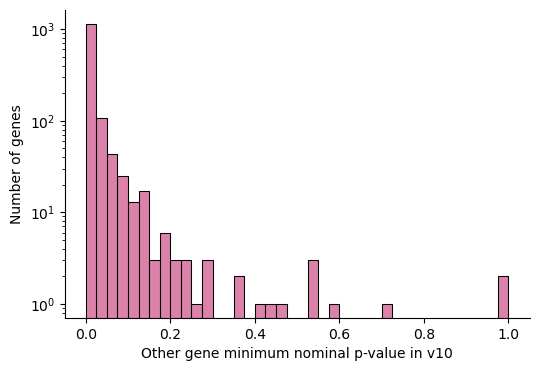

In [ ]:
# show the distirbution of minimum p values for all the new qtls
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(new_eqtls, x='pval_nominal', ax=ax, bins=40,
             multiple='dodge', color='#b70657', alpha=.5)
ax.set_yscale('log')
ax.set_xlabel('Other gene minimum nominal p-value in v10')
ax.set_ylabel('Number of genes')
ax.spines[['top', 'right']].set_visible(False)




### p value replicaiton for genes in both

In [ ]:
v10_dir_path = 'data/qtls/GTEx_Analysis_v10_eQTL_all_associations'
v10_nominal = pd.read_parquet(f'{v10_dir_path}/Brain_Caudate_basal_ganglia.v10.allpairs.chr20.parquet')

In [ ]:
v11_dir_path = 'output/caudate_analysis/eqtls'
v11_nominal = pd.read_parquet(f'{v11_dir_path}/Brain_Caudate_basal_ganglia.v11.allpairs.chr20.parquet')

In [ ]:
v11_nominal['stable_gene_id'] = v11_nominal['gene_id'].str.split('.').str[0]
v10_nominal['stable_gene_id'] = v10_nominal['gene_id'].str.split('.').str[0]

In [ ]:
combined_nominal = pd.merge(v11_nominal, v10_nominal, on=['stable_gene_id', 'variant_id'], how='inner', suffixes=['_v11', '_v10'])

In [ ]:
combined_nominal.head()

,gene_id_v11,variant_id,tss_distance_v11,af_v11,ma_samples_v11,ma_count_v11,pval_nominal_v11,slope_v11,slope_se_v11,stable_gene_id,gene_id_v10,tss_distance_v10,af_v10,ma_samples_v10,ma_count_v10,pval_nominal_v10,slope_v10,slope_se_v10
0,ENSG00000196476.12,chr20_61066_T_C_b38,-229712,0.031136,15,17,0.891040,0.017690,0.129003,ENSG00000196476,ENSG00000196476.12,-229712,0.031136,15,17,0.891226,0.017889,0.130674
1,ENSG00000196476.12,chr20_61083_C_T_b38,-229695,0.117450,66,70,0.911256,-0.006818,0.061105,ENSG00000196476,ENSG00000196476.12,-229695,0.117450,66,70,0.890088,-0.008557,0.061855
2,ENSG00000196476.12,chr20_61098_C_T_b38,-229680,0.018456,11,11,0.232625,-0.172433,0.144101,ENSG00000196476,ENSG00000196476.12,-229680,0.018456,11,11,0.305388,-0.150000,0.146040
3,ENSG00000196476.12,chr20_63971_TTCCATTCCAC_T_b38,-226807,0.199664,104,119,0.988032,0.000697,0.046404,ENSG00000196476,ENSG00000196476.12,-226807,0.199664,104,119,0.995781,0.000249,0.047005
4,ENSG00000196476.12,chr20_65927_A_C_b38,-224851,0.008389,5,5,0.813563,-0.055428,0.234775,ENSG00000196476,ENSG00000196476.12,-224851,0.008389,5,5,0.807254,-0.057503,0.235439


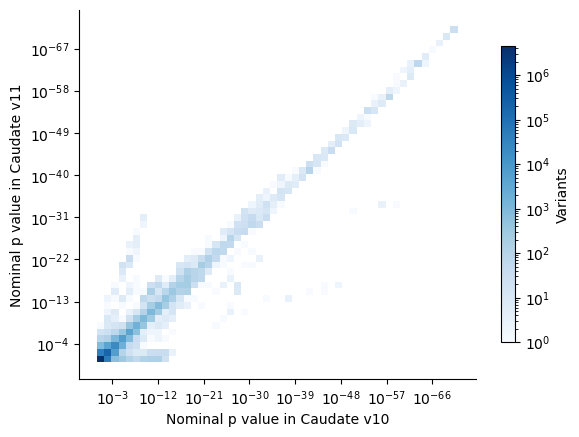

In [ ]:
ax = sns.histplot(combined_nominal, x='pval_nominal_v10', y='pval_nominal_v11', bins=50, norm=LogNorm(), log_scale=True,
                  vmin=None, vmax=None, cbar=True, cmap=sns.color_palette("Blues", as_cmap=True), cbar_kws={'shrink':.8, 'label':'Variants'})
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('Nominal p value in Caudate v10')
ax.set_ylabel('Nominal p value in Caudate v11')
ax.invert_xaxis()
ax.invert_yaxis()


In [ ]:
combined_nominal['pval_nominal_v10'].corr(combined_nominal['pval_nominal_v11'])

0.8964576041596874